In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [4]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [5]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [6]:
# fix random seed for reproducibility
np.random.seed(42)

In [7]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [8]:
%%time
X_lt_FNM128, y_lt_FNM128, X_rt_FNM128, y_rt_FNM128, X_lb_FNM128, y_lb_FNM128, X_rb_FNM128, y_rb_FNM128, X_ct_FNM128, y_ct_FNM128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByMeaning_128_3dim",
                                ["GazolineStation", "Hotel", "Parking", "Restaurant", "Taxi", "TollRoad", "Transport"])

Wall time: 28.5 s


In [9]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [10]:
### VGG16, without retrain

def run_VGG16_without_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = VGG16(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = False
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    #model.add(Dropout(0.4))
    #model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=10, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 20s 6ms/step - loss: 6.9368 - acc: 0.5155 - val_loss: 4.7212 - val_acc: 0.6733
Epoch 2/300
3123/3123 [==============================] - 15s 5ms/step

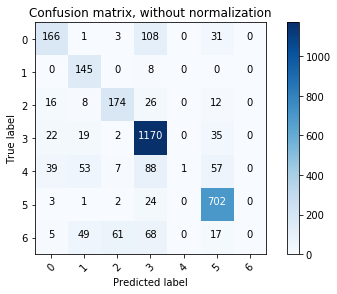

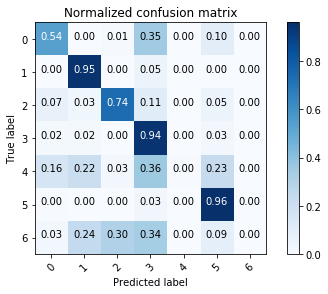

Confusion matrix, without normalization
[[  9   0   1  22   0   3   0]
 [  0  14   0   4   0   0   0]
 [  0   0  26   1   0   0   0]
 [  2   1   1 126   0   9   0]
 [  3   7   0  10   0   8   0]
 [  1   0   1   7   0  73   0]
 [  1   7   9   3   0   3   0]]
Normalized confusion matrix
[[0.25714286 0.         0.02857143 0.62857143 0.         0.08571429
  0.        ]
 [0.         0.77777778 0.         0.22222222 0.         0.
  0.        ]
 [0.         0.         0.96296296 0.03703704 0.         0.
  0.        ]
 [0.01438849 0.00719424 0.00719424 0.90647482 0.         0.0647482
  0.        ]
 [0.10714286 0.25       0.         0.35714286 0.         0.28571429
  0.        ]
 [0.01219512 0.         0.01219512 0.08536585 0.         0.8902439
  0.        ]
 [0.04347826 0.30434783 0.39130435 0.13043478 0.         0.13043478
  0.        ]]


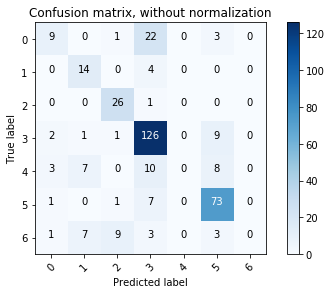

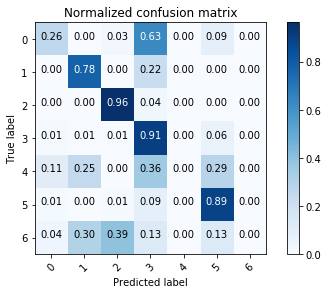

Wall time: 3min 59s


In [11]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNM128, y_ct_FNM128, num_categories=7)


model_ct, history_ct, test_scores_ct = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [12]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.7045454545454546


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 16s 5ms/step - loss: 7.6688 - acc: 0.4755 - val_loss: 7.3608 - val_acc: 0.5057
Epoch 2/300
3123/3123 [==============================] - 16s 5ms/step

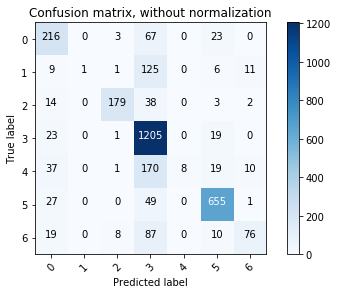

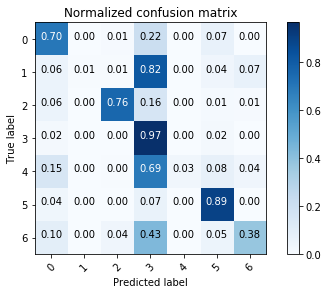

Confusion matrix, without normalization
[[ 17   0   0  17   0   1   0]
 [  1   0   0  14   0   1   2]
 [  1   0  17   1   0   1   7]
 [  5   0   0 131   0   3   0]
 [  3   0   0  13   0   1  11]
 [  1   0   0  22   0  59   0]
 [  3   0   3   3   0   4  10]]
Normalized confusion matrix
[[0.48571429 0.         0.         0.48571429 0.         0.02857143
  0.        ]
 [0.05555556 0.         0.         0.77777778 0.         0.05555556
  0.11111111]
 [0.03703704 0.         0.62962963 0.03703704 0.         0.03703704
  0.25925926]
 [0.03597122 0.         0.         0.94244604 0.         0.02158273
  0.        ]
 [0.10714286 0.         0.         0.46428571 0.         0.03571429
  0.39285714]
 [0.01219512 0.         0.         0.26829268 0.         0.7195122
  0.        ]
 [0.13043478 0.         0.13043478 0.13043478 0.         0.17391304
  0.43478261]]


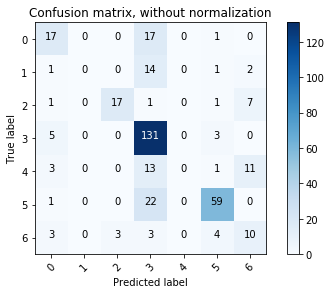

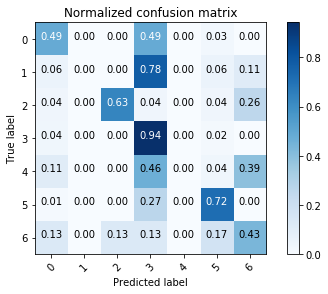

Wall time: 6min 46s


In [13]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNM128, y_lt_FNM128, num_categories=7)


model_lt, history_lt, test_scores_lt = run_VGG16_without_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [14]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.6647727272727273


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 17s 5ms/step - loss: 9.4463 - acc: 0.4006 - val_loss: 9.6394 - val_acc: 0.3977
Epoch 2/300
3123/3123 [==============================] - 16s 5ms/step

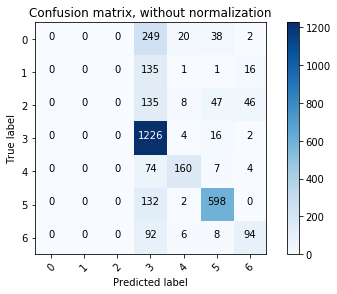

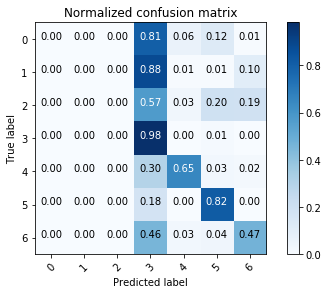

Confusion matrix, without normalization
[[  0   0   0  31   2   1   1]
 [  0   0   0  17   0   0   1]
 [  0   0   0   3   0   7  17]
 [  0   0   0 131   4   3   1]
 [  0   0   0  13   3   2  10]
 [  0   0   0  31   0  51   0]
 [  0   0   0  13   2   0   8]]
Normalized confusion matrix
[[0.         0.         0.         0.88571429 0.05714286 0.02857143
  0.02857143]
 [0.         0.         0.         0.94444444 0.         0.
  0.05555556]
 [0.         0.         0.         0.11111111 0.         0.25925926
  0.62962963]
 [0.         0.         0.         0.94244604 0.02877698 0.02158273
  0.00719424]
 [0.         0.         0.         0.46428571 0.10714286 0.07142857
  0.35714286]
 [0.         0.         0.         0.37804878 0.         0.62195122
  0.        ]
 [0.         0.         0.         0.56521739 0.08695652 0.
  0.34782609]]


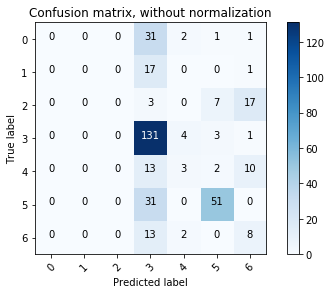

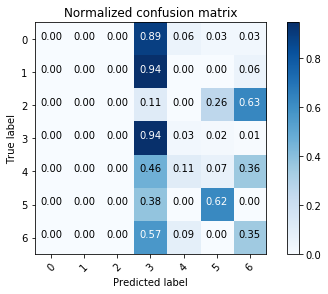

Wall time: 12min 8s


In [19]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNM128, y_rt_FNM128, num_categories=7)


model_rt, history_rt, test_scores_rt = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [20]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.5482954545454546


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 16s 5ms/step - loss: 7.8852 - acc: 0.4694 - val_loss: 7.1903 - val_acc: 0.5312
Epoch 2/300
3123/3123 [==============================] - 15s 5ms/step

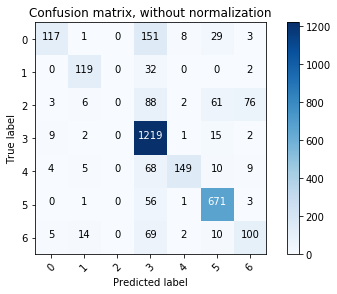

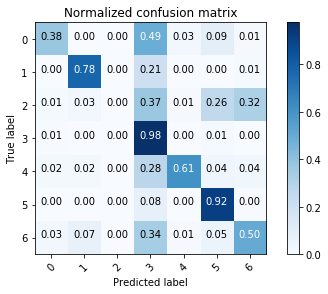

Confusion matrix, without normalization
[[  2   2   0  31   0   0   0]
 [  0  11   0   7   0   0   0]
 [  1   0   0   2   0   2  22]
 [  1   2   0 122   2  12   0]
 [  0   8   0   5   6   1   8]
 [  0   3   0  13   0  65   1]
 [  1   0   0   2   2   1  17]]
Normalized confusion matrix
[[0.05714286 0.05714286 0.         0.88571429 0.         0.
  0.        ]
 [0.         0.61111111 0.         0.38888889 0.         0.
  0.        ]
 [0.03703704 0.         0.         0.07407407 0.         0.07407407
  0.81481481]
 [0.00719424 0.01438849 0.         0.87769784 0.01438849 0.08633094
  0.        ]
 [0.         0.28571429 0.         0.17857143 0.21428571 0.03571429
  0.28571429]
 [0.         0.03658537 0.         0.15853659 0.         0.79268293
  0.01219512]
 [0.04347826 0.         0.         0.08695652 0.08695652 0.04347826
  0.73913043]]


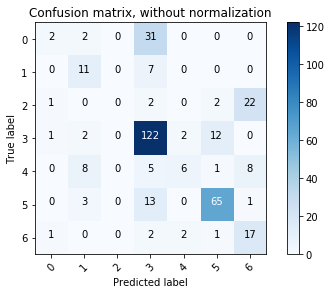

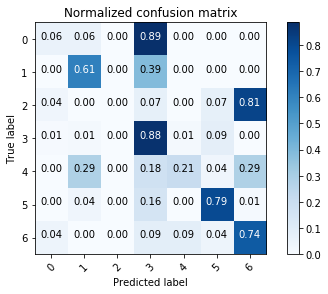

Wall time: 8min 7s


In [21]:
%%time
model_rt_1, history_rt_1, test_scores_rt_1 = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [22]:
print("right_top result accuracy:", test_scores_rt_1[1])

right_top result accuracy: 0.6335227272727273


In [23]:
model_rt = model_rt_1
history_rt = history_rt_1
test_scores_rt = test_scores_rt_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 17s 5ms/step - loss: 7.7086 - acc: 0.4797 - val_loss: 6.0446 - val_acc: 0.5994
Epoch 2/300
3123/3123 [==============================] - 16s 5ms/step

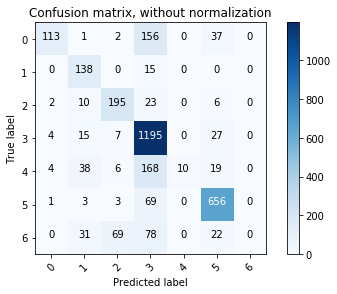

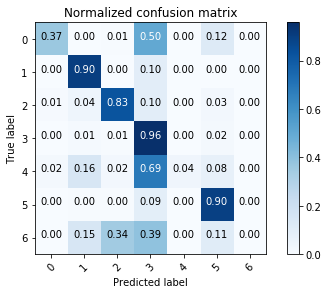

Confusion matrix, without normalization
[[  3   0   2  27   0   3   0]
 [  0  14   1   3   0   0   0]
 [  0   0  26   0   0   1   0]
 [  2   2   5 122   0   8   0]
 [  0   9   2  16   0   1   0]
 [  1   0   2  14   0  65   0]
 [  0   1  17   2   1   2   0]]
Normalized confusion matrix
[[0.08571429 0.         0.05714286 0.77142857 0.         0.08571429
  0.        ]
 [0.         0.77777778 0.05555556 0.16666667 0.         0.
  0.        ]
 [0.         0.         0.96296296 0.         0.         0.03703704
  0.        ]
 [0.01438849 0.01438849 0.03597122 0.87769784 0.         0.05755396
  0.        ]
 [0.         0.32142857 0.07142857 0.57142857 0.         0.03571429
  0.        ]
 [0.01219512 0.         0.02439024 0.17073171 0.         0.79268293
  0.        ]
 [0.         0.04347826 0.73913043 0.08695652 0.04347826 0.08695652
  0.        ]]


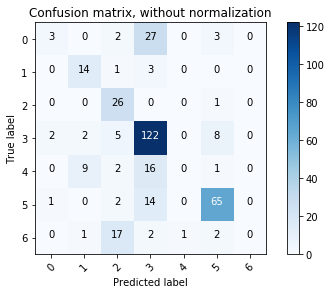

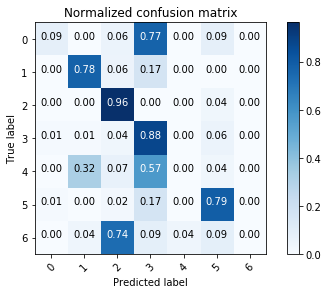

Wall time: 3min 25s


In [24]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNM128, y_lb_FNM128, num_categories=7)


model_lb, history_lb, test_scores_lb = run_VGG16_without_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [25]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.6534090909090909


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 57351     
Total params: 14,772,039
Trainable params: 57,351
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 17s 5ms/step - loss: 7.7349 - acc: 0.4701 - val_loss: 7.2117 - val_acc: 0.5312
Epoch 2/300
3123/3123 [==============================] - 16s 5ms/step

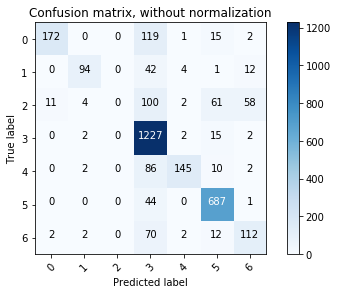

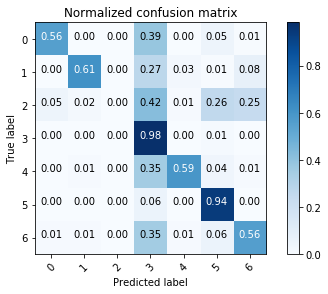

Confusion matrix, without normalization
[[  5   0   0  29   0   1   0]
 [  0   9   0   7   0   0   2]
 [  1   0   0   2   0   3  21]
 [  6   0   0 127   1   3   2]
 [  1   4   0  18   1   1   3]
 [  3   0   0  13   0  65   1]
 [  0   0   0   4   0   3  16]]
Normalized confusion matrix
[[0.14285714 0.         0.         0.82857143 0.         0.02857143
  0.        ]
 [0.         0.5        0.         0.38888889 0.         0.
  0.11111111]
 [0.03703704 0.         0.         0.07407407 0.         0.11111111
  0.77777778]
 [0.04316547 0.         0.         0.91366906 0.00719424 0.02158273
  0.01438849]
 [0.03571429 0.14285714 0.         0.64285714 0.03571429 0.03571429
  0.10714286]
 [0.03658537 0.         0.         0.15853659 0.         0.79268293
  0.01219512]
 [0.         0.         0.         0.17391304 0.         0.13043478
  0.69565217]]


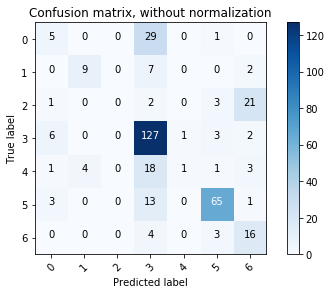

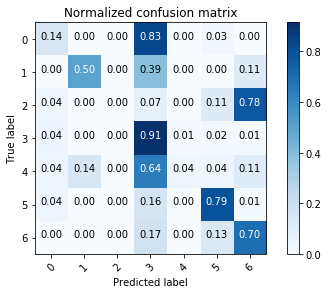

Wall time: 8min 33s


In [26]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNM128, y_rb_FNM128, num_categories=7)


model_rb, history_rb, test_scores_rb = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=7,
                                                                           patience=7)

In [27]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.6335227272727273


## Validation accuracy results

In [28]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.7045
left_top result accuracy: 0.6648
right_top result accuracy: 0.6335
left_bottom result accuracy: 0.6534
right_bottom result accuracy: 0.6335


In [29]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [30]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(3123, 35)


In [31]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(352, 35)


In [32]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByMeaning128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByMeaning128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByMeaning128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByMeaning128.npy"
np.save(file_path_y_test, y_ct_test)

In [33]:
#np.load(file_path_un_train)

test accuracy:  0.6477

Confusion matrix, without normalization
[[ 249    1    2   42    0   15    0]
 [  35  100    0    8    2    2    6]
 [  35    3  172   19    1    4    2]
 [  87   10    1 1143    3    4    0]
 [ 138   13    0   66   10   15    3]
 [  56    1    0    8    2  665    0]
 [  49   15   12   50    0    6   68]]
Normalized confusion matrix
[[8.05825243e-01 3.23624595e-03 6.47249191e-03 1.35922330e-01
  0.00000000e+00 4.85436893e-02 0.00000000e+00]
 [2.28758170e-01 6.53594771e-01 0.00000000e+00 5.22875817e-02
  1.30718954e-02 1.30718954e-02 3.92156863e-02]
 [1.48305085e-01 1.27118644e-02 7.28813559e-01 8.05084746e-02
  4.23728814e-03 1.69491525e-02 8.47457627e-03]
 [6.97115385e-02 8.01282051e-03 8.01282051e-04 9.15865385e-01
  2.40384615e-03 3.20512821e-03 0.00000000e+00]
 [5.63265306e-01 5.30612245e-02 0.00000000e+00 2.69387755e-01
  4.08163265e-02 6.12244898e-02 1.22448980e-02]
 [7.65027322e-02 1.36612022e-03 0.00000000e+00 1.09289617e-02
  2.73224044e-03 9.08469945e-

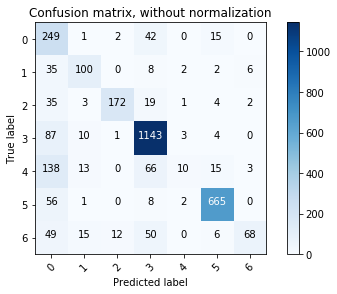

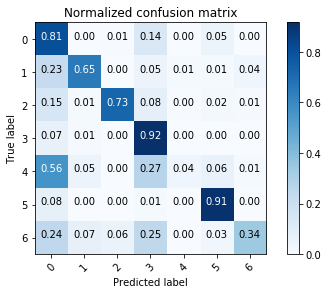

Confusion matrix, without normalization
[[ 16   0   0  17   0   2   0]
 [  6   9   0   2   0   1   0]
 [  1   0  18   1   0   0   7]
 [ 16   1   0 120   0   2   0]
 [ 18   0   0   5   0   3   2]
 [ 18   0   0   4   2  58   0]
 [  5   1   0   3   0   4  10]]
Normalized confusion matrix
[[0.45714286 0.         0.         0.48571429 0.         0.05714286
  0.        ]
 [0.33333333 0.5        0.         0.11111111 0.         0.05555556
  0.        ]
 [0.03703704 0.         0.66666667 0.03703704 0.         0.
  0.25925926]
 [0.11510791 0.00719424 0.         0.86330935 0.         0.01438849
  0.        ]
 [0.64285714 0.         0.         0.17857143 0.         0.10714286
  0.07142857]
 [0.2195122  0.         0.         0.04878049 0.02439024 0.70731707
  0.        ]
 [0.2173913  0.04347826 0.         0.13043478 0.         0.17391304
  0.43478261]]


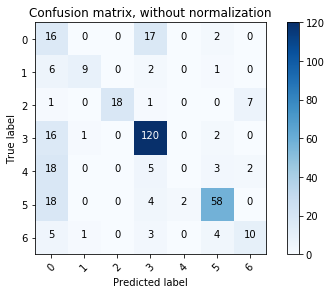

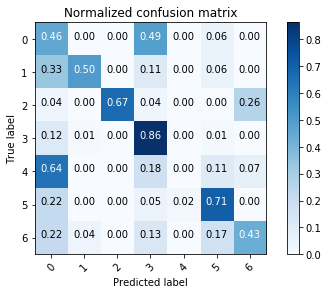

In [34]:
#let's try KNN first
categories_count = 7

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [35]:
# write predicted result into file

In [36]:
knn_uniform_15_predict_train = knn_uniform_15.predict(predict_un_train)
knn_uniform_15_predict_test = knn_uniform_15.predict(predict_un_test)

file_path_knn_uniform_15_train = "./knn_uniform_15_train_France_ByMeaning128.npy"
np.save(file_path_knn_uniform_15_train, knn_uniform_15_predict_train)

file_path_knn_uniform_15_test = "./knn_uniform_15_test_France_ByMeaning128.npy"
np.save(file_path_knn_uniform_15_test, knn_uniform_15_predict_test)


test accuracy:  0.6847

Confusion matrix, without normalization
[[ 307    0    0    2    0    0    0]
 [   0  153    0    0    0    0    0]
 [   0    0  236    0    0    0    0]
 [   1    0    0 1247    0    0    0]
 [   0    0    0    2  243    0    0]
 [   0    0    0    0    0  732    0]
 [   0    2    0    0    0    0  198]]
Normalized confusion matrix
[[9.93527508e-01 0.00000000e+00 0.00000000e+00 6.47249191e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.01282051e-04 0.00000000e+00 0.00000000e+00 9.99198718e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.16326531e-03
  9.91836735e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+

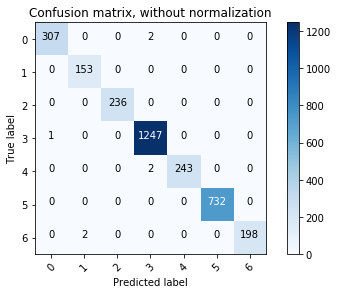

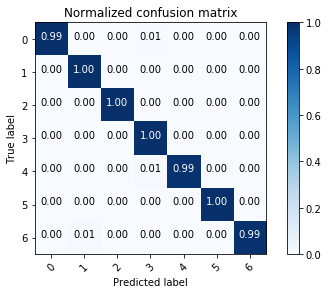

Confusion matrix, without normalization
[[ 15   0   1  17   0   2   0]
 [  3  12   0   2   1   0   0]
 [  1   0  18   1   0   0   7]
 [ 12   1   0 119   2   5   0]
 [ 11   0   0   5   5   5   2]
 [ 13   0   0   4   3  62   0]
 [  3   2   0   3   0   4  11]]
Normalized confusion matrix
[[0.42857143 0.         0.02857143 0.48571429 0.         0.05714286
  0.        ]
 [0.16666667 0.66666667 0.         0.11111111 0.05555556 0.
  0.        ]
 [0.03703704 0.         0.66666667 0.03703704 0.         0.
  0.25925926]
 [0.08633094 0.00719424 0.         0.85611511 0.01438849 0.03597122
  0.        ]
 [0.39285714 0.         0.         0.17857143 0.17857143 0.17857143
  0.07142857]
 [0.15853659 0.         0.         0.04878049 0.03658537 0.75609756
  0.        ]
 [0.13043478 0.08695652 0.         0.13043478 0.         0.17391304
  0.47826087]]


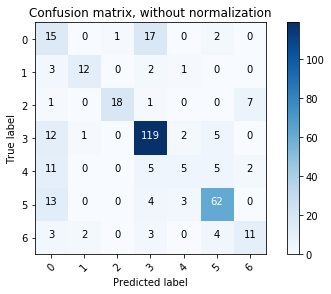

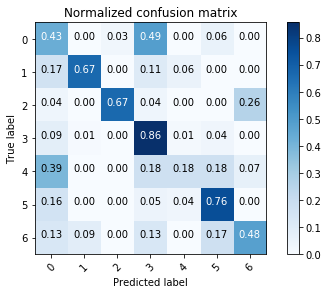

In [37]:
#let's try KNN with another weights
categories_count = 7

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [38]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./knn_distance_15_train_France_ByMeaning128.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./knn_distance_15_test_France_ByMeaning128.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [39]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.7244



In [40]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./svm_train_France_ByMeaning128.npy"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./svm_test_France_ByMeaning128.npy"
np.save(file_path_svm_test, svm_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               18432     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 1799      
Total params: 151,559
Trainable params: 151,559
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/300
3123/3123 [==============================] - 9s 3ms/step - loss: 0.7955 

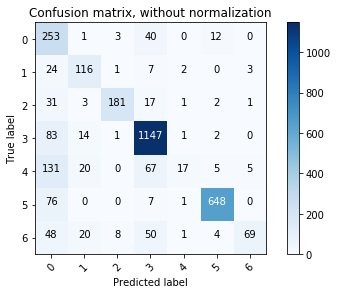

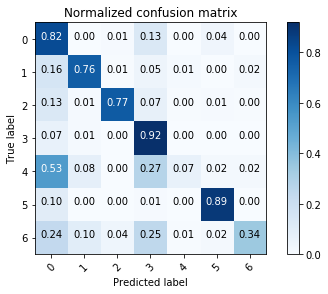

Confusion matrix, without normalization
[[ 17   0   0  17   0   1   0]
 [  5  11   0   1   0   0   1]
 [  3   0  17   0   0   0   7]
 [ 14   1   0 121   0   3   0]
 [ 17   3   0   5   1   0   2]
 [ 19   0   0   5   0  57   1]
 [  5   3   1   2   0   1  11]]
Normalized confusion matrix
[[0.48571429 0.         0.         0.48571429 0.         0.02857143
  0.        ]
 [0.27777778 0.61111111 0.         0.05555556 0.         0.
  0.05555556]
 [0.11111111 0.         0.62962963 0.         0.         0.
  0.25925926]
 [0.10071942 0.00719424 0.         0.8705036  0.         0.02158273
  0.        ]
 [0.60714286 0.10714286 0.         0.17857143 0.03571429 0.
  0.07142857]
 [0.23170732 0.         0.         0.06097561 0.         0.69512195
  0.01219512]
 [0.2173913  0.13043478 0.04347826 0.08695652 0.         0.04347826
  0.47826087]]


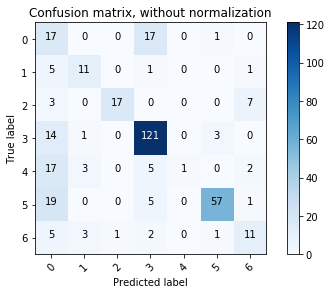

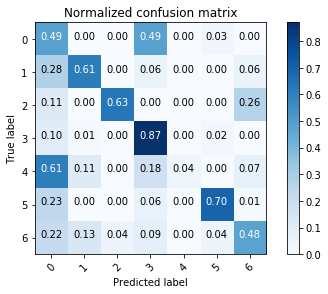

Wall time: 1min 39s


In [41]:
%%time
# and also multilayer neuron net
categories_count = 7

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [42]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.7216
best test accuracy: 0.7415


In [43]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./meta_net_train_France_ByMeaning128.npy"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./meta_net_test_France_ByMeaning128.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)
